In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

In [2]:
month_day_fmt = mdates.DateFormatter('%m/%d')

In [3]:
day_df = pd.read_pickle('day.pkl')
total_df = pd.read_pickle('total.pkl')

# Folkhälsomyndigheten states that data is incomplete for last 2 days, remove those along with 'unknown data'
day_complete_df = day_df[:-3]

### Population is fetched from [SCB](http://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101A/BefolkningR1860)

In [4]:
pop_2020 = pd.read_pickle('external/pop_2020-02.pkl')
pop_agegroup = pop_2020.loc[pop_2020['region'] == 'Riket'].groupby('agegroup')['value'].sum()
pop_sex = pop_2020.loc[pop_2020['region'] == 'Riket'].groupby('sex')['value'].sum()
pop_regions = pop_2020.groupby('region').sum()['value']
pop_regions = pop_regions.loc[pop_regions.index != 'Riket']

In [5]:
reindices = [ndx[:-4] if ndx[:-4][-1] != 's' else ndx[:-5] for ndx in pop_regions.index]
reindices[5] = 'Jämtland_Härjedalen'
reindices[12] = 'Sörmland'
reindices[-3] = 'Västra_Götaland'
pop_regions.index = reindices

In [6]:
total_df.loc[total_df.region.notna(), 'population'] = pop_regions.to_numpy()
# total_df.loc[total_df.agegroup.notna(), 'population'] = pop_agegroup.to_numpy()
# total_df.loc

In [7]:
male_per_100k = 1000 * 100 * total_df.loc[total_df.sex == 'Man', 'total_cases']/pop_sex[1]
female_per_100k = 1000 * 100 * total_df.loc[total_df.sex == 'Kvinna', 'total_cases']/pop_sex[0]
total_df.loc[total_df.sex == 'Man', 'cases_per_100k'] = male_per_100k
total_df.loc[total_df.sex == 'Kvinna', 'cases_per_100k'] = female_per_100k

In [8]:
total_df.loc[total_df.agegroup == '80-90', 'agegroup'] = '80-89'
agegroup_rows = total_df[total_df.agegroup.notna()]
age_cases_per_100k = 1000 * 100 * agegroup_rows.total_cases[:-1]/pop_agegroup.to_numpy()
age_cases_per_100k
total_df.loc[total_df.agegroup.notna(), 'cases_per_100k'] = age_cases_per_100k

In [9]:
day_complete_df = day_complete_df.assign(
    rolling_5_cases=day_df.rolling(5, min_periods=3, center=True).mean()['total_cases'],
    rolling_7_cases=day_df.rolling(7, min_periods=3, center=True).mean()['total_cases'],
)

In [10]:
assert total_df.loc[total_df['region'].notna(), 'total_cases'].sum() == day_df.total_cases.sum()
assert total_df.loc[total_df['region'].notna(), 'total_deceased'].sum() == day_df.total_deceased.sum()
assert total_df.loc[total_df['region'].notna(), 'total_icu'].sum() == day_df.total_icu.sum()

## There should be no assertion errors!
## Otherwise there is discrepancies in total data report and daily data

In [11]:
age_df = total_df.loc[total_df.agegroup.notna(),total_df.columns[2:]]
age_df['cases_percentage'] = age_df['cases_per_100k']/1000
age_df['deceased_percentage'] = 100 * age_df['total_deceased']/age_df['total_cases']
age_df['icu_percentage'] = 100 * age_df['total_icu']/age_df['total_cases']
age_df

,agegroup,total_cases,cases_per_100k,total_icu,total_deceased,population,cases_percentage,deceased_percentage,icu_percentage
0,0-9,59,4.736418,1,0,NaN,0.004736,0.000000,1.694915
1,10-19,156,13.229095,0,0,NaN,0.013229,0.000000,0.000000
2,20-29,754,56.692156,35,3,NaN,0.056692,0.397878,4.641910
3,30-39,951,69.497883,36,2,NaN,0.069498,0.210305,3.785489
4,40-49,1310,100.865829,90,4,NaN,0.100866,0.305344,6.870229
5,50-59,1759,135.582090,198,34,NaN,0.135582,1.932916,11.256396
6,60-69,1407,127.105208,236,64,NaN,0.127105,4.548685,16.773276
7,70-79,1419,144.011935,165,228,NaN,0.144012,16.067653,11.627907
8,80-89,1536,356.328425,27,362,NaN,0.356328,23.567708,1.757812
9,90+,793,829.272374,1,190,NaN,0.829272,23.959647,0.126103


In [12]:
print(f'Totalt antal smittade: {int(day_df.total_cases.sum())}')
print(f'Totalt antal dödsfall: {int(day_df.total_deceased.sum())}')
print(f'Totalt antal intensivvårdade: {int(day_df.total_icu.sum())}')
print(f'Procentuell andel positivt testade av befolkningen: {100*day_df.total_cases.sum()/pop_agegroup.sum():.3}%')
print(f'Ratio dödsfall/positivt testade: {100*day_df.total_deceased.sum()/day_df.total_cases.sum():.3}%')

Totalt antal smittade: 10151
Totalt antal dödsfall: 887
Totalt antal intensivvårdade: 789
Procentuell andel positivt testade av befolkningen: 0.0982%
Ratio dödsfall/positivt testade: 8.74%


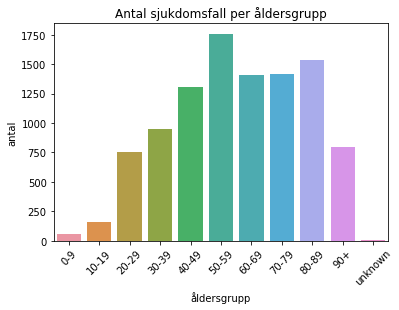

In [13]:
ax = sns.barplot('agegroup', 'total_cases', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal sjukdomsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='antal')

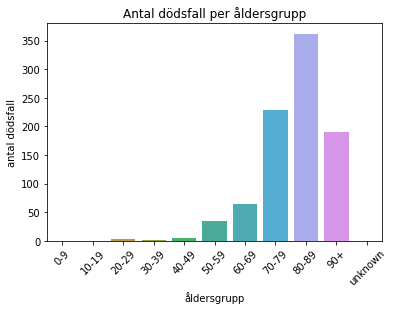

In [14]:
ax = sns.barplot('agegroup', 'total_deceased', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal dödsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='antal dödsfall')

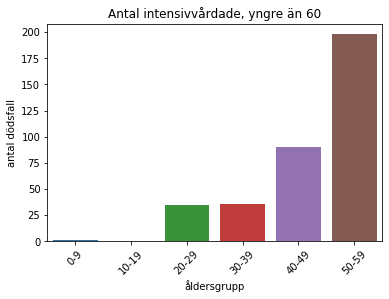

In [15]:
ax = sns.barplot('agegroup', 'total_icu', data=age_df.loc[:5])
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal intensivvårdade, yngre än 60', xlabel='åldersgrupp', ylabel='antal dödsfall')

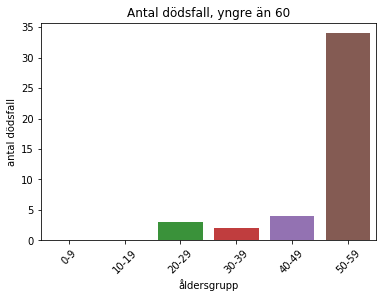

In [16]:
ax = sns.barplot('agegroup', 'total_deceased', data=age_df.loc[:5])
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal dödsfall, yngre än 60', xlabel='åldersgrupp', ylabel='antal dödsfall')

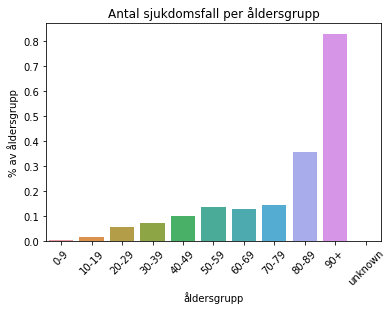

In [17]:
ax = sns.barplot('agegroup', 'cases_percentage', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal sjukdomsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='% av åldersgrupp')

In [18]:
def autolabel_above(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(round(rect.get_height()))
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [19]:
def autolabel_beside(rects):
    """Attach a text label to the right of each bar in *rects*, displaying its width."""
    for rect in rects:
        width = int(round(rect.get_width()))
        ax.annotate('{}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(4, -5),
                    textcoords="offset points",
                    ha='center', va='bottom')

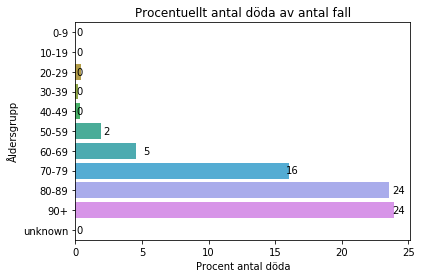

In [20]:
ax = sns.barplot('deceased_percentage', 'agegroup', data=age_df)
autolabel_beside(ax.patches)
_ = ax.set(title='Procentuellt antal döda av antal fall', xlabel='Procent antal döda', ylabel='Åldersgrupp')

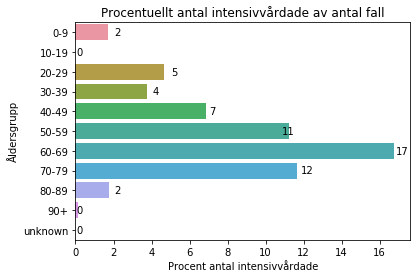

In [21]:
ax = sns.barplot('icu_percentage', 'agegroup', data=age_df)
autolabel_beside(ax.patches)
_ = ax.set(title='Procentuellt antal intensivvårdade av antal fall', xlabel='Procent antal intensivvårdade', ylabel='Åldersgrupp')

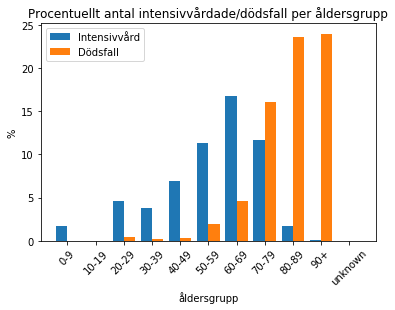

In [22]:
xpos = np.arange(len(age_df.icu_percentage))
width = .4

fig, ax = plt.subplots()
rects1 = plt.bar(xpos-width/2, age_df.icu_percentage, width, label='Intensivvård')
rects2 = plt.bar(xpos+width/2, age_df.deceased_percentage, width, label='Dödsfall')

ax.set_xticks(xpos)
ax.set_xticklabels(age_df.agegroup, rotation=45)
ax.legend()
_ = ax.set(title='Procentuellt antal intensivvårdade/dödsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='%')

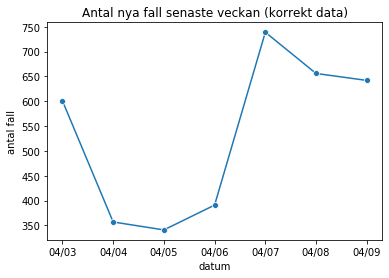

In [23]:
ax = sns.lineplot('date', 'total_cases', data=day_complete_df[-7:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste veckan (korrekt data)', xlabel='datum', ylabel='antal fall')

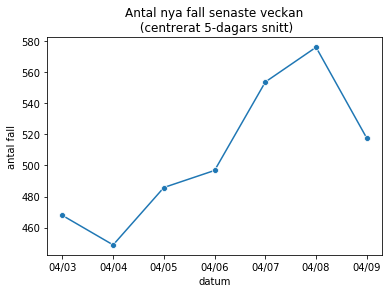

In [24]:
ax = sns.lineplot('date', 'rolling_5_cases', data=day_complete_df[-7:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste veckan\n (centrerat 5-dagars snitt)', xlabel='datum', ylabel='antal fall')

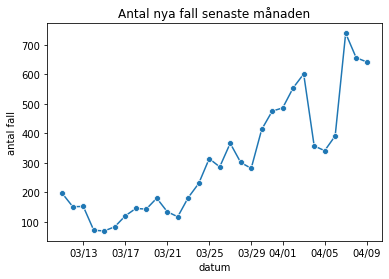

In [25]:
ax = sns.lineplot('date', 'total_cases', data=day_complete_df[-30:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste månaden', xlabel='datum', ylabel='antal fall')

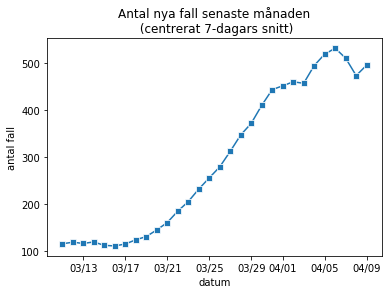

In [26]:
ax = sns.lineplot('date', 'rolling_7_cases', data=day_complete_df[-30:], marker='s')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste månaden\n (centrerat 7-dagars snitt)', xlabel='datum', ylabel='antal fall')

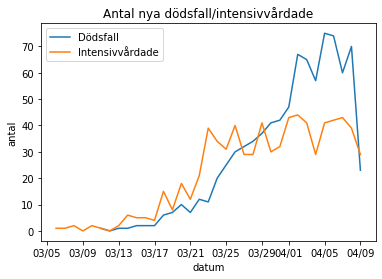

In [27]:
sns.lineplot('date', 'total_deceased', data=day_complete_df)
ax = sns.lineplot('date', 'total_icu', data=day_complete_df)
ax.xaxis.set_major_formatter(month_day_fmt)
ax.set(title='Antal nya dödsfall/intensivvårdade', xlabel='datum', ylabel='antal')
_ = ax.legend(['Dödsfall', 'Intensivvårdade'])

# De intressantaste regionerna...

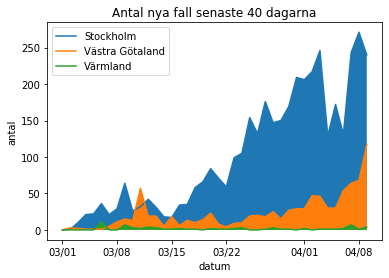

In [28]:
sns.lineplot('date', 'Stockholm', data=day_complete_df[-40:])
sns.lineplot('date', 'Västra_Götaland', data=day_complete_df[-40:])
ax = sns.lineplot('date', 'Värmland', data=day_complete_df[-40:])

ax.fill_between(day_complete_df[-40:].date, day_complete_df[-40:]['Stockholm'])
ax.fill_between(day_complete_df[-40:].date, day_complete_df[-40:]['Västra_Götaland'])
ax.fill_between(day_complete_df[-40:].date, day_complete_df[-40:]['Värmland'])

ax.xaxis.set_major_formatter(month_day_fmt)
ax.set(title='Antal nya fall senaste 40 dagarna', xlabel='datum', ylabel='antal')
_ = ax.legend(['Stockholm', 'Västra Götaland', 'Värmland'])

In [29]:
day_complete_percent = day_complete_df.copy(deep=True)
for col in day_complete_percent.columns[2:-4]:
    day_complete_percent[col] = 100 * day_complete_df[col]/pop_regions[col]

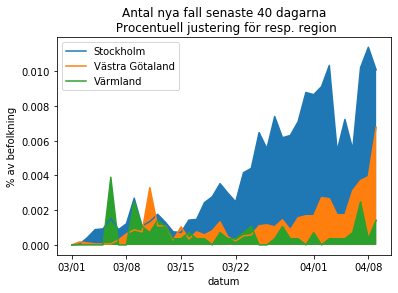

In [31]:
sns.lineplot('date', 'Stockholm', data=day_complete_percent[-40:])
sns.lineplot('date', 'Västra_Götaland', data=day_complete_percent[-40:])
ax = sns.lineplot('date', 'Värmland', data=day_complete_percent[-40:])

ax.fill_between(day_complete_percent[-40:].date, day_complete_percent[-40:]['Stockholm'])
ax.fill_between(day_complete_percent[-40:].date, day_complete_percent[-40:]['Västra_Götaland'])
ax.fill_between(day_complete_percent[-40:].date, day_complete_percent[-40:]['Värmland'])

ax.xaxis.set_major_formatter(month_day_fmt)
ax.set(title='Antal nya fall senaste 40 dagarna\n Procentuell justering för resp. region', xlabel='datum', ylabel='% av befolkning')
_ = ax.legend(['Stockholm', 'Västra Götaland', 'Värmland'])